In [ ]:
# all library used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz # string manipulation
from thefuzz import process
import missingno # like mice package in r, msno.matrix(df)
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.graphics.mosaicplot import mosaic
import pyarrow.feather as feather
import random
import pingouin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from pyspark.sql import SparkSession


# Cleaning Data in Python

In [84]:
# Import library
import pandas as pd
from thefuzz import fuzz # string manipulation
import missingno # like mice package in r, msno.matrix(df)

In [85]:
# fuzz library
#fuzz.WRatio('Reeding', 'Reading')
# score: 0 => not similar
# score: 100 => exact match

from thefuzz import process
string = 'Houston Rockets vs Los Angeles Lakers'
choices = pd.Series(['Rocket vs Lakers', 'Lakers vs Rockets', 'Houson vs Los Angeles', 'Heat vs Bulls'])
process.extract(string, choices, limit = 2)

[('Rocket vs Lakers', 86, 0), ('Lakers vs Rockets', 86, 1)]

# Introduction to Regression with statsmodels in Python

In [86]:
# import the ols function
from statsmodels.formula.api import ols
import pandas as pd

In [87]:
taiwan_real_estate = pd.read_csv('./Simple Linear Regression Modeling/Data/taiwan_real_estate2.csv')
taiwan_real_estate.head()

,dist_to_mrt_m,n_convenience,house_age_years,price_twd_msq
0,84.87882,10,30 to 45,11.467474
1,306.59470,9,15 to 30,12.768533
2,561.98450,5,0 to 15,14.311649
3,561.98450,5,0 to 15,16.580938
4,390.56840,5,0 to 15,13.040847


### Fitting a linear regression

In [88]:
# create the model object
mdl_price_vs_conv = ols('price_twd_msq ~ n_convenience', data = taiwan_real_estate)

# fit the model
mdl_price_vs_conv = mdl_price_vs_conv.fit()

# print model parameter
print(mdl_price_vs_conv.params)

Intercept        8.224237
n_convenience    0.798080
dtype: float64


### Categorical explanatory variable

### Making predictions

use .predict(), use .assign() to extrapolate

In [89]:
little_beam = pd.DataFrame({'length':[10]})
little_beam

,length
0,10


### Regression to the mean

### Plotting consecutive portfolio returns

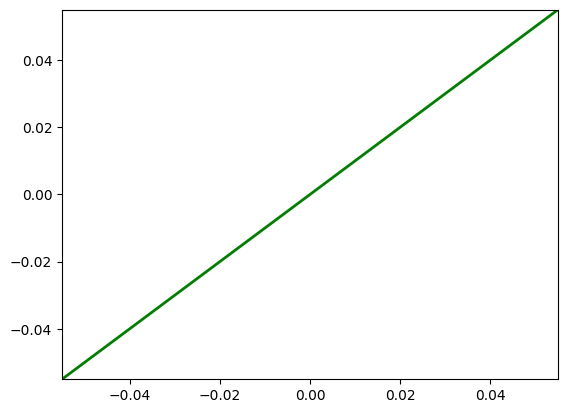

In [90]:
# import matplotlib
import matplotlib.pyplot as plt

# create a new figure
fig = plt.figure()

# plot the first layer
plt.axline(xy1 = (0,0), slope = 1, linewidth = 2, color = 'green')

# add scatter plot with linear regression trend line

### Transforming variables

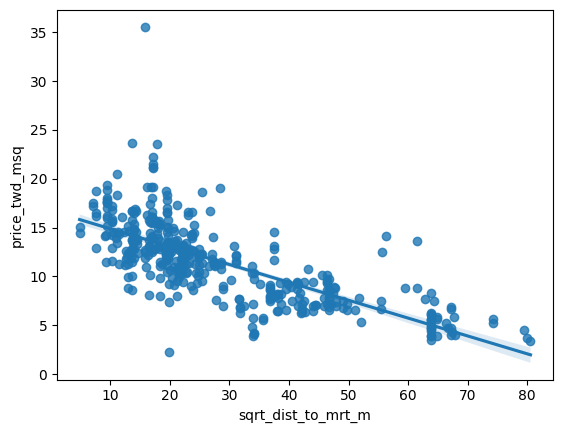

In [91]:
# import numerical python & seaborn
import numpy as np
import seaborn as sns

# create square root of the distance between mrt and real estate
taiwan_real_estate['sqrt_dist_to_mrt_m'] = np.sqrt(taiwan_real_estate['dist_to_mrt_m'])

plt.figure()

# plot transformed variable
sns.regplot(x = 'sqrt_dist_to_mrt_m', y = 'price_twd_msq', 
            data = taiwan_real_estate)
plt.show()

In [92]:
# fit a linear regression
mdl_price_vs_dist = ols('price_twd_msq ~ sqrt_dist_to_mrt_m', 
                        data = taiwan_real_estate).fit()

# print parameters (coefficients)
print(mdl_price_vs_dist.params)

Intercept             16.709799
sqrt_dist_to_mrt_m    -0.182843
dtype: float64


In [93]:
# perdiction
#prediction_data = pd.DataFrame({'price_twd_msq': })

In [94]:
ad_conversion = pd.read_csv('./Simple Linear Regression Modeling/Data/ad_conversion.csv')
ad_conversion.head()

,spent_usd,n_impressions,n_clicks
0,1.43,7350,1
1,1.82,17861,2
2,1.25,4259,1
3,1.29,4133,1
4,4.77,15615,3


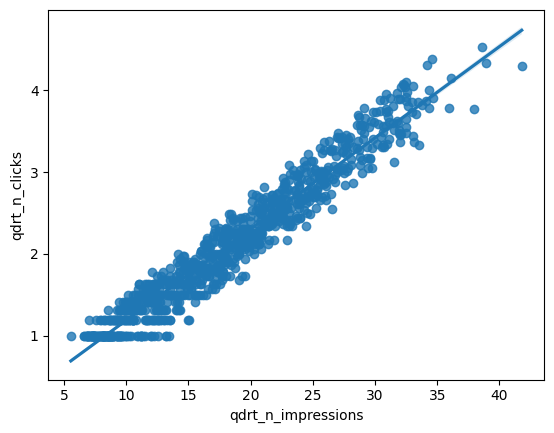

In [95]:
# create 
ad_conversion['qdrt_n_impressions'] = ad_conversion['n_impressions'] ** 0.25
ad_conversion['qdrt_n_clicks'] = ad_conversion['n_clicks'] ** 0.25

plt.figure()

# plot using transformed variable
sns.regplot(x = 'qdrt_n_impressions', y = 'qdrt_n_clicks', data = ad_conversion)
plt.show()

In [96]:
# run a linear regression using transformed variables
mdl_click_vs_impression = ols('qdrt_n_clicks ~ qdrt_n_impressions', 
                              data = ad_conversion).fit()

## Assessing model fit
### Quantifying model fit

### Visualizing model fit

### Outliers, leverage, and influence
Leverage measures how unusual or extreme the explanatory variables are for each observation. 
* High leverage : explanatory variables has values that are different from other points in the dataset
Influence : how much a model would change if each observation was left out of the model calculations, one at a time. Cook's distance

In [97]:
# create summary info
summary_info = mdl_price_vs_dist.get_influence().summary_frame()
summary_info.head()

,dfb_Intercept,dfb_sqrt_dist_to_mrt_m,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.094893,0.073542,4.648246e-03,-1.266363,0.005764,-0.096418,-1.267294,-0.096489
1,-0.013981,0.008690,1.216711e-04,-0.262996,0.003506,-0.015599,-0.262699,-0.015582
2,0.025510,-0.009963,6.231096e-04,0.688143,0.002625,0.035302,0.687703,0.035279
3,0.055525,-0.021686,2.939394e-03,1.494602,0.002625,0.076673,1.496850,0.076789
4,-0.000932,0.000518,6.055123e-07,-0.019716,0.003106,-0.001100,-0.019692,-0.001099


In [98]:
# add the hat_diag column to taiwan_real_estate, name it leverage
taiwan_real_estate['leverage'] = summary_info['hat_diag']

# sort taiwan_real_estate by leverage in descending order and print the head
print(taiwan_real_estate.sort_values('leverage', ascending = False).head())

     dist_to_mrt_m  n_convenience house_age_years  price_twd_msq  \
347       6488.021              1        15 to 30       3.388805   
116       6396.283              1        30 to 45       3.691377   
249       6306.153              1        15 to 30       4.538578   
8         5512.038              1        30 to 45       5.688351   
255       5512.038              1        30 to 45       5.264750   

     sqrt_dist_to_mrt_m  leverage  
347           80.548253  0.026665  
116           79.976765  0.026135  
249           79.411290  0.025617  
8             74.243101  0.021142  
255           74.243101  0.021142  


In [99]:
# Add the cooks_d column to taiwan_real_estate, name it cooks_dist
taiwan_real_estate['cooks_dist'] = summary_info['cooks_d']

# Sort taiwan_real_estate by cooks_dist in descending order and print the head.
print(taiwan_real_estate.sort_values('cooks_dist', ascending = False).head())

     dist_to_mrt_m  n_convenience house_age_years  price_twd_msq  \
270       252.5822              1         0 to 15      35.552194   
148      3780.5900              0        15 to 30      13.645991   
228      3171.3290              0         0 to 15      14.099849   
220       186.5101              9        30 to 45      23.691377   
113       393.2606              6         0 to 15       2.299546   

     sqrt_dist_to_mrt_m  leverage  cooks_dist  
270           15.892835  0.003849    0.115549  
148           61.486503  0.012147    0.052440  
228           56.314554  0.009332    0.035384  
220           13.656870  0.004401    0.025123  
113           19.830799  0.003095    0.022813  


## Simple logistic regression modeling
### why you need logictic regression

In [100]:
# load churn dataset
churn = pd.read_csv('./Simple Linear Regression Modeling/Data/churn.csv')
churn.head()

,has_churned,time_since_first_purchase,time_since_last_purchase
0,0,-1.089221,-0.721322
1,0,1.182983,3.634435
2,0,-0.846156,-0.427582
3,0,0.086942,-0.535672
4,0,-1.166642,-0.672640


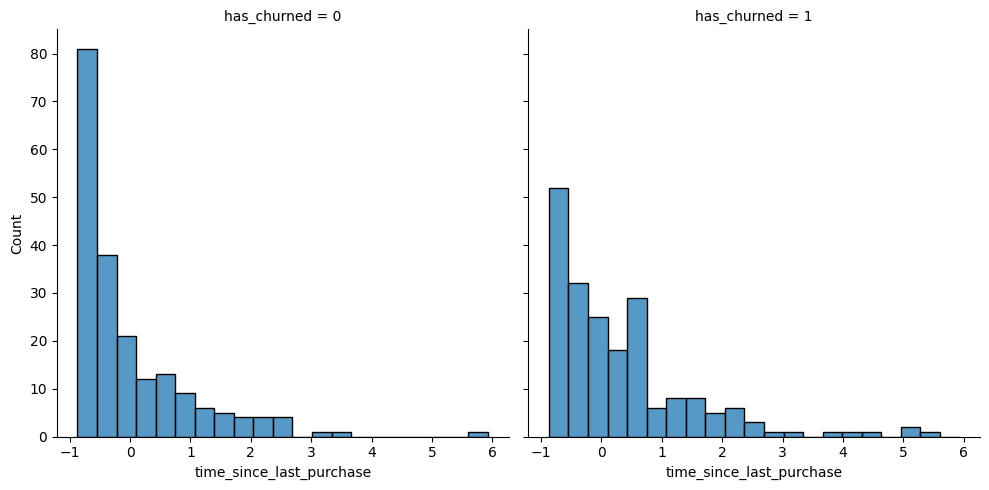

In [101]:
# create the histograms of time_since_last_purchase split by has_churned
sns.displot(x = 'time_since_last_purchase', col = 'has_churned',
            data = churn)
plt.show()

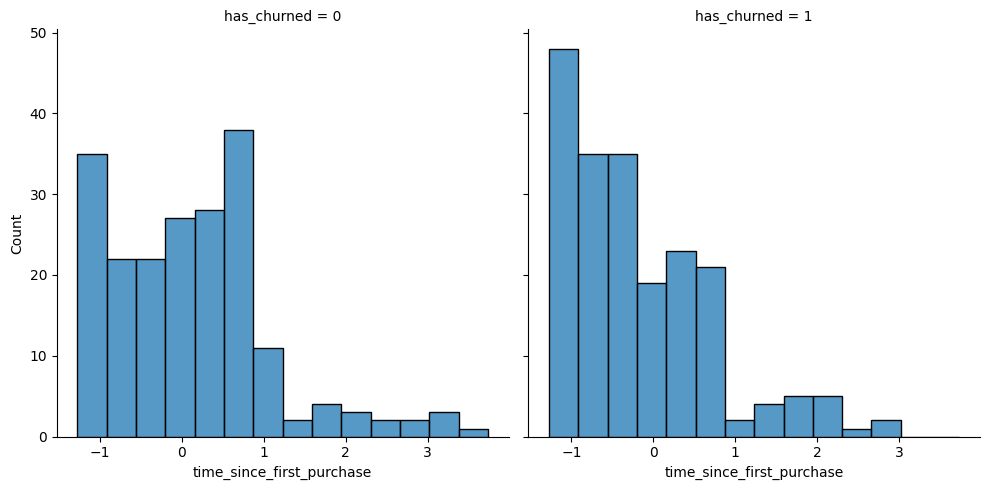

In [102]:
# redraw the plot with time_since_firts_purchase
sns.displot(x = 'time_since_first_purchase', 
            col = 'has_churned',
            data = churn)
plt.show()

From the plot above, we can see that churners typically have longer times sicne their last purchase (distribution of churned customers was further right than the distribution of non-churned customers)

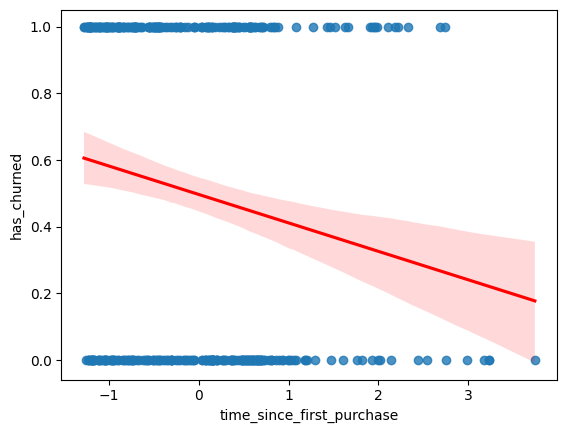

In [103]:
# draw a linear regression trend line and a scatter plot of time_since_first_purchase vs. has_churned
sns.regplot(x = 'time_since_first_purchase', 
            y = 'has_churned', 
            data = churn,
            line_kws={'color':'red'})
plt.show()

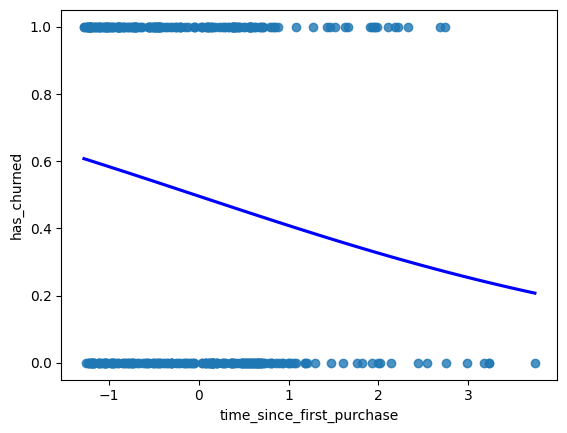

In [104]:
# draw a logistic regression trend line and a scatter plot of time_since_first_purchase vs. has_churned
sns.regplot(x = 'time_since_first_purchase',
            y = 'has_churned',
            data = churn,
            ci = None,
            logistic = True,
            line_kws = {'color': 'blue'}
            );

In [105]:
# import logit
from statsmodels.formula.api import logit

# fit a logistic regression
mdl_churn_recency_logit = logit('has_churned ~ time_since_first_purchase',
                                data = churn).fit()

# print the parameters of the fitted model
print(mdl_churn_recency_logit.params)

Optimization terminated successfully.
         Current function value: 0.679663
         Iterations 4
Intercept                   -0.015185
time_since_first_purchase   -0.354795
dtype: float64


### Predictions and odds ratios

In [106]:
# create explanatory data
explanatory_data = pd.DataFrame({'time_since_first_purchase':np.arange(-1.50,4.25,0.25)})

# create a prediction data
prediction_data = explanatory_data.assign(has_churned = mdl_churn_recency_logit.predict(explanatory_data))

In [107]:
# update prediction data with most likely outcome
prediction_data['most_likely_outcome'] = np.round(prediction_data['has_churned'])
prediction_data.head(5)

,time_since_first_purchase,has_churned,most_likely_outcome
0,-1.50,0.626448,1.0
1,-1.25,0.605470,1.0
2,-1.00,0.584096,1.0
3,-0.75,0.562401,1.0
4,-0.50,0.540465,1.0


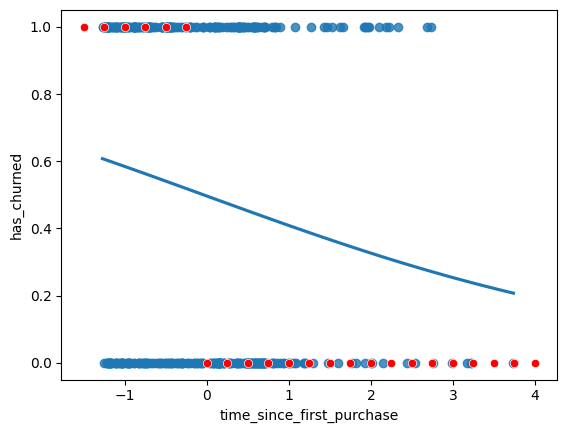

In [108]:
fig = plt.figure()

# create a scatter plot with logistic trend line
sns.regplot(x = 'time_since_first_purchase',
            y = 'has_churned',
            data = churn,
            ci = None,
            logistic = True)

# overlay with prediction data
sns.scatterplot(x = 'time_since_first_purchase',
                y = 'most_likely_outcome',
                data=prediction_data,
                color='red')

plt.show()

Odds ratio : probability of something happening divided by the probability that it doesn't

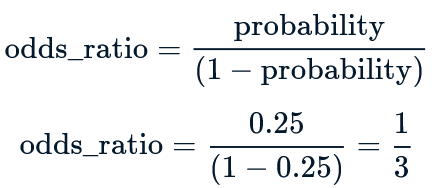

In [109]:
# update prediction data with odds ratio
prediction_data['odds_ratio'] = prediction_data['has_churned']/(1-prediction_data['has_churned'])
prediction_data.head(5)

,time_since_first_purchase,has_churned,most_likely_outcome,odds_ratio
0,-1.50,0.626448,1.0,1.677003
1,-1.25,0.605470,1.0,1.534661
2,-1.00,0.584096,1.0,1.404400
3,-0.75,0.562401,1.0,1.285197
4,-0.50,0.540465,1.0,1.176111


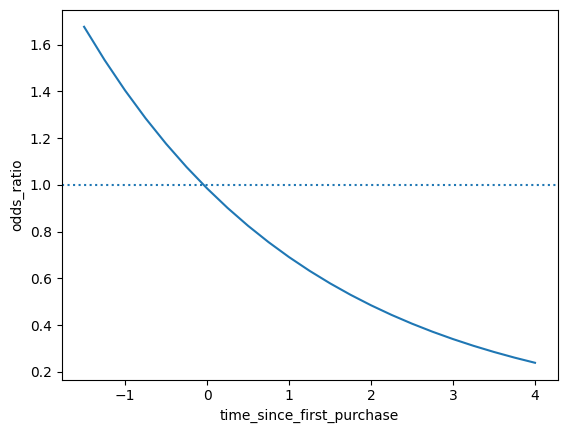

In [110]:
# create a line plot of odds ratio vs time since first purchase
sns.lineplot(data=prediction_data,
             x='time_since_first_purchase',
             y='odds_ratio')

# add a dotted horizontal line at odds_ratio = 1
plt.axhline(y=1, linestyle='dotted')

plt.show()

In [111]:
# update prediction data with log_odds_ratio
prediction_data['log_odds_ratio'] = np.log(prediction_data['odds_ratio'])
prediction_data.head(5)

,time_since_first_purchase,has_churned,most_likely_outcome,odds_ratio,log_odds_ratio
0,-1.50,0.626448,1.0,1.677003,0.517008
1,-1.25,0.605470,1.0,1.534661,0.428309
2,-1.00,0.584096,1.0,1.404400,0.339610
3,-0.75,0.562401,1.0,1.285197,0.250912
4,-0.50,0.540465,1.0,1.176111,0.162213


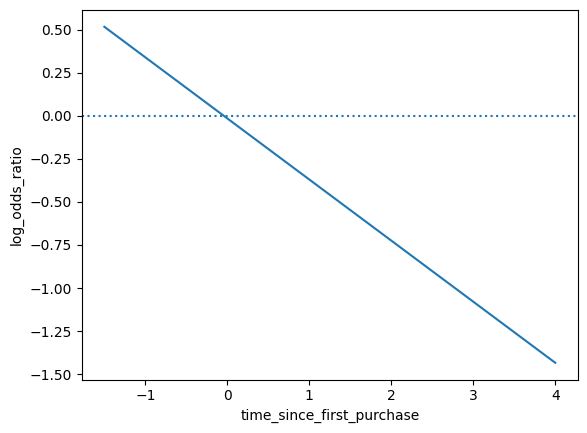

In [112]:
# update the line plot
sns.lineplot(data=prediction_data,
             x='time_since_first_purchase',
             y='log_odds_ratio')

# add a dotted horizontal line at log odds ratio  = 0
plt.axhline(y=0, linestyle='dotted')

plt.show()

Confusion matrix

In [113]:
# get the actual response
actual_response = churn['has_churned']

# get predicted response
predicted_response = np.round(mdl_churn_recency_logit.predict())

# create the outcome
outcome = pd.DataFrame({'actual_response':actual_response,
                        'predicted_response':predicted_response})

print(outcome.value_counts(sort=False))

actual_response  predicted_response
0                0.0                   112
                 1.0                    88
1                0.0                    76
                 1.0                   124
Name: count, dtype: int64


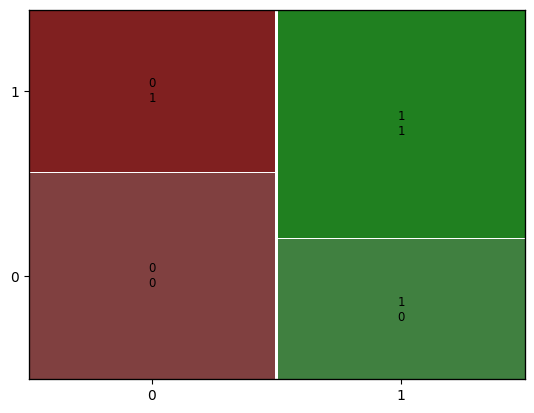

In [114]:
# import mosaic
from statsmodels.graphics.mosaicplot import mosaic

# calculate the confusion matrix
conf_matrix = mdl_churn_recency_logit.pred_table()

# draw a mosaic plot
mosaic(conf_matrix)
plt.show()

* Accuracy: proportion of correct predictions
* sensitivity: proportion of true positive
* specificity: proportion of true negative
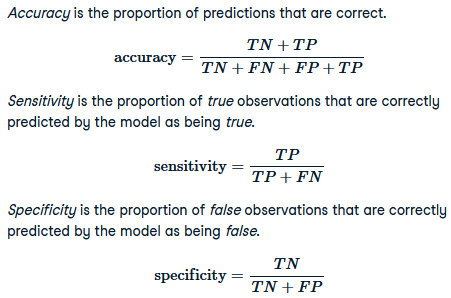

In [115]:
# extract value from conf_matrix
TN = conf_matrix[0,0]
TP = conf_matrix[1,1]
FN = conf_matrix[1,0]
FP = conf_matrix[0,1]

# Calculate and print the accuracy
accuracy = (TN + TP)/(TN + FN + FP + TP)
print("accuracy: ", accuracy)

# Calculate and print the sensitivity
sensitivity = TP/(TP + FN)
print("sensitivity: ", sensitivity)

# Calculate and print the specificity
specificity = TN / (TN + FP)
print("specificity: ", specificity)

accuracy:  0.59
sensitivity:  0.62
specificity:  0.56


# Sampling in Python
## Introduction to sampling

## Sampling methods
* Simple random and systematic sampling
* Stratified and weighted random sampling
* Cluster sampling

In [116]:
import pyarrow.feather as feather

# load .feather file
table = feather.read_table('./Sampling in Python/Data/attrition.feather')

# convert to pandas dataframe
attrition_pop = table.to_pandas()

# display dataframe
print(attrition_pop.head())

   Age  Attrition     BusinessTravel  DailyRate            Department  \
0   21        0.0      Travel_Rarely        391  Research_Development   
1   19        1.0      Travel_Rarely        528                 Sales   
2   18        1.0      Travel_Rarely        230  Research_Development   
3   18        0.0      Travel_Rarely        812                 Sales   
4   18        1.0  Travel_Frequently       1306                 Sales   

   DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
0                15        College  Life_Sciences                    High   
1                22  Below_College      Marketing               Very_High   
2                 3       Bachelor  Life_Sciences                    High   
3                10       Bachelor        Medical               Very_High   
4                 5       Bachelor      Marketing                  Medium   

   Gender  ...  PerformanceRating RelationshipSatisfaction  StockOptionLevel  \
0    Male  ...    

In [117]:
# proportion of employees by education level
education_counts_pop = attrition_pop['Education'].value_counts(normalize=True)
education_counts_pop

Education
Bachelor         0.389116
Master           0.270748
College          0.191837
Below_College    0.115646
Doctor           0.032653
Name: proportion, dtype: float64

In [118]:
# proportional stratified sampling for 40% of each education group
attrition_strat = attrition_pop.groupby('Education').sample(frac=0.4, random_state=2022)
attrition_strat

C:\Users\user\AppData\Local\Temp\ipykernel_19244\1145584223.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_strat = attrition_pop.groupby('Education').sample(frac=0.4, random_state=2022)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1191,53,0.0,Travel_Rarely,238,Sales,1,Below_College,Medical,Very_High,Female,...,Outstanding,Very_High,0,18,2,Best,14,7,8,10
407,29,0.0,Travel_Frequently,995,Research_Development,2,Below_College,Life_Sciences,Low,Male,...,Excellent,Very_High,1,6,0,Best,6,4,1,3
1233,59,0.0,Travel_Frequently,1225,Sales,1,Below_College,Life_Sciences,Low,Female,...,Excellent,Very_High,0,20,2,Good,4,3,1,3
366,37,0.0,Travel_Rarely,571,Research_Development,10,Below_College,Life_Sciences,Very_High,Female,...,Excellent,Medium,2,6,3,Good,5,3,4,3
702,31,0.0,Travel_Frequently,163,Research_Development,24,Below_College,Technical_Degree,Very_High,Female,...,Outstanding,Very_High,0,9,3,Good,5,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,38,0.0,Travel_Frequently,653,Research_Development,29,Doctor,Life_Sciences,Very_High,Female,...,Excellent,Very_High,0,10,2,Better,10,3,9,9
1061,44,0.0,Travel_Frequently,602,Human_Resources,1,Doctor,Human_Resources,Low,Male,...,Excellent,High,0,14,3,Better,10,7,0,2
1307,41,0.0,Travel_Rarely,1276,Sales,2,Doctor,Life_Sciences,Medium,Female,...,Excellent,Medium,1,22,2,Better,18,16,11,8
1060,33,0.0,Travel_Rarely,516,Research_Development,8,Doctor,Life_Sciences,Very_High,Male,...,Excellent,Low,0,14,6,Better,0,0,0,0


In [119]:
# calculat the education level proportion from attrition_strat
education_counts_strat = attrition_strat['Education'].value_counts(normalize = True)
education_counts_strat

Education
Bachelor         0.389456
Master           0.270408
College          0.192177
Below_College    0.115646
Doctor           0.032313
Name: proportion, dtype: float64

by grouping then sampling, the size of each group in the sample is representative of the size of the sample in the population

In [120]:
# get 30 employee from each education group
attrition_eq = attrition_pop.groupby('Education').sample(n=30, random_state=2022)

# get the proportion from attrition_eq
education_counts_eq = attrition_eq['Education'].value_counts(normalize=True)

education_counts_eq

C:\Users\user\AppData\Local\Temp\ipykernel_19244\498766193.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_eq = attrition_pop.groupby('Education').sample(n=30, random_state=2022)


Education
Below_College    0.2
College          0.2
Bachelor         0.2
Master           0.2
Doctor           0.2
Name: proportion, dtype: float64

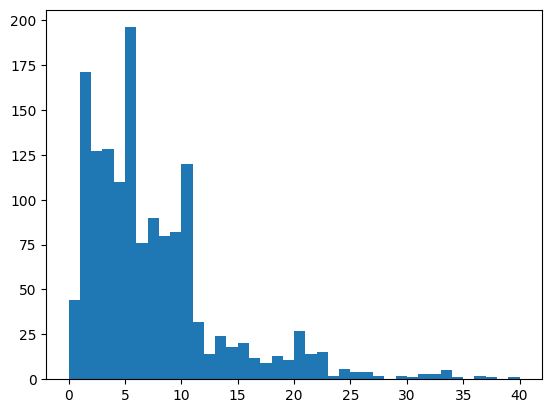

In [121]:
# plot years at company from attrition pop as a histogram
plt.hist(attrition_pop['YearsAtCompany'], bins=np.arange(0,41,1))
plt.show();

<Axes: >

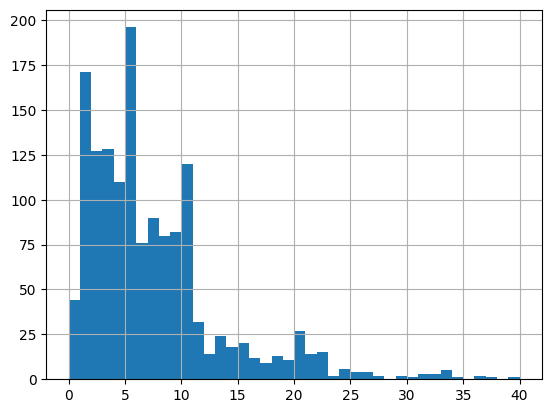

In [122]:
# alternative way
attrition_pop['YearsAtCompany'].hist(bins=np.arange(0,41,1))

Weighted sampling

In [123]:
# load coffee_ratings_full.feather
table = feather.read_table("Sampling in Python/Data/coffee_ratings_full.feather")

# convert to pandas data frame
coffee_ratings = table.to_pandas()

# display data
coffee_ratings.head()

,total_cup_points,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,90.58,Arabica,metad plc,Ethiopia,metad plc,None,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0.0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,89.92,Arabica,metad plc,Ethiopia,metad plc,None,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1.0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,89.75,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",None,None,None,None,1600 - 1800 m,...,None,0.0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,89.00,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,None,wolensu,None,yidnekachew debessa coffee plantation,1800-2200,...,Green,2.0,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,88.83,Arabica,metad plc,Ethiopia,metad plc,None,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2.0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [124]:
coffee_ratings['country_of_origin'].value_counts()

country_of_origin
Mexico                          236
Colombia                        183
Guatemala                       181
Brazil                          132
Taiwan                           75
United States (Hawaii)           73
Honduras                         52
Costa Rica                       51
Ethiopia                         44
Tanzania, United Republic Of     40
Uganda                           36
Thailand                         32
Nicaragua                        26
Kenya                            25
El Salvador                      21
Indonesia                        20
China                            16
India                            14
Malawi                           11
Peru                             10
United States                    10
Vietnam                           8
Myanmar                           8
Haiti                             6
Philippines                       5
Panama                            4
United States (Puerto Rico)       4
Ecuador   

In [125]:
# filtering for the top 6 countries
top_counted_countries = ["Mexico", "Columbia", "Guatemala", "Brazil", "Taiwan", "United States (Hawaii)"]
top_counted_countries

['Mexico',
 'Columbia',
 'Guatemala',
 'Brazil',
 'Taiwan',
 'United States (Hawaii)']

In [126]:
# alternative ways
top_6_names = list(coffee_ratings['country_of_origin'].value_counts().index[:6])
top_6_names

['Mexico',
 'Colombia',
 'Guatemala',
 'Brazil',
 'Taiwan',
 'United States (Hawaii)']

In [127]:
# subset data frame to only rows from the top 6 countries
top_counted_subset = coffee_ratings['country_of_origin'].isin(top_counted_countries)
coffee_ratings_top = coffee_ratings[top_counted_subset]

# display data frame
coffee_ratings_top.head()

,total_cup_points,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
2,89.75,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",None,None,None,None,1600 - 1800 m,...,None,0.0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
5,88.83,Arabica,ji-ae ahn,Brazil,None,None,None,None,None,None,...,Bluish-Green,1.0,"September 3rd, 2014",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
13,87.92,Arabica,grounds for health admin,United States (Hawaii),arianna farms,None,None,None,None,2000 ft,...,None,2.0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,609.6,609.6,609.6
22,87.17,Arabica,roberto licona franco,Mexico,la herradura,None,la herradura,0,None,1320,...,Green,0.0,"July 26th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,1320.0,1320.0,1320.0
25,86.92,Arabica,nucoffee,Brazil,fazenda kaquend,None,None,002/1251/0073,nucoffee,1250m,...,Green,2.0,"December 2nd, 2012",NUCOFFEE,567f200bcc17a90070cb952647bf88141ad9c80c,aa2ff513ffb9c844462a1fb07c599bce7f3bb53d,m,1250.0,1250.0,1250.0


In [128]:
# copy coffee ratings top
coffee_ratings_weight = coffee_ratings_top

# set country condition to only Taiwan
condition = coffee_ratings_weight["country_of_origin"] == "Taiwan"

# set Taiwan to 2 and others to 1
coffee_ratings_weight['weight'] = np.where(condition, 2, 1)

# sampling
coffee_ratings_weight = coffee_ratings_weight.sample(frac=0.1, weights = "weight")

C:\Users\user\AppData\Local\Temp\ipykernel_19244\1161266630.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee_ratings_weight['weight'] = np.where(condition, 2, 1)


In [129]:
# 10% weighted sample
coffee_ratings_weight['country_of_origin'].value_counts(normalize = True)

country_of_origin
Mexico                    0.357143
Guatemala                 0.228571
Taiwan                    0.185714
Brazil                    0.114286
United States (Hawaii)    0.114286
Name: proportion, dtype: float64

Practice

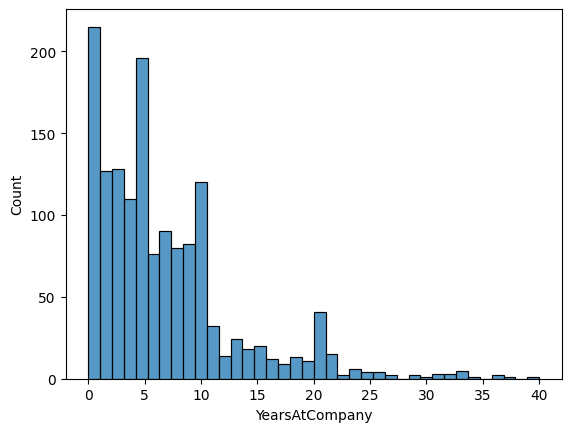

In [130]:
# Plot Years at company from attrition Population as a histogram
sns.histplot(data = attrition_pop,
             x = 'YearsAtCompany')
plt.show();

In [131]:
# sample 400 employees weighted by years at company
attrition_weight = attrition_pop.sample(n=400, weights = "YearsAtCompany")

# print the sample
attrition_weight

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
659,27,0.0,Travel_Rarely,975,Research_Development,7,Bachelor,Medical,Very_High,Female,...,Excellent,Low,0,9,2,Bad,7,6,0,7
1215,39,0.0,Travel_Rarely,1132,Research_Development,1,Bachelor,Medical,High,Male,...,Excellent,Low,3,19,5,Good,18,10,3,7
1375,44,0.0,Travel_Rarely,1315,Research_Development,3,Master,Other,Very_High,Male,...,Excellent,Low,1,26,2,Best,2,2,0,1
566,26,1.0,Travel_Frequently,887,Research_Development,5,College,Medical,High,Female,...,Excellent,Low,1,8,2,Better,8,7,1,7
979,30,0.0,Non-Travel,1116,Research_Development,2,Bachelor,Medical,High,Female,...,Excellent,High,0,12,2,Good,11,7,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,33,0.0,Travel_Frequently,515,Research_Development,1,College,Life_Sciences,Low,Female,...,Excellent,High,0,15,1,Better,15,14,8,12
97,38,0.0,Travel_Rarely,1380,Research_Development,9,College,Life_Sciences,High,Female,...,Excellent,High,0,2,3,Better,2,2,2,1
1096,34,0.0,Travel_Rarely,1326,Sales,3,Bachelor,Other,Very_High,Male,...,Excellent,Very_High,0,15,2,Better,13,9,3,12
460,37,0.0,Travel_Rarely,228,Sales,6,Master,Medical,High,Male,...,Excellent,Medium,1,7,5,Best,5,4,0,1


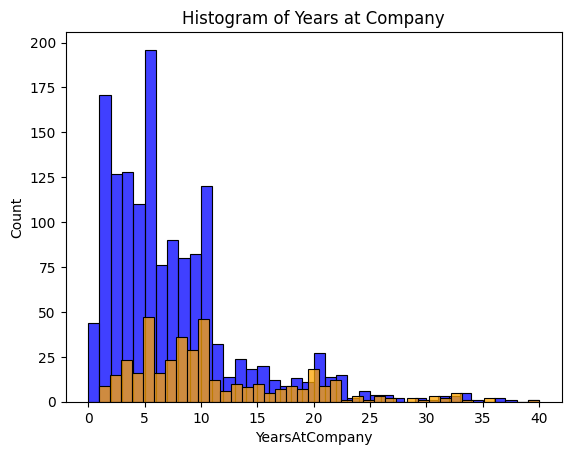

In [132]:
# Plot Years at company from attrition Population as a histogram
sns.histplot(data = attrition_pop,
             x = 'YearsAtCompany',
             color='blue',
             bins = 40)

# plot years at company from attrion_weight as a histogram
sns.histplot(data = attrition_weight,
             x = "YearsAtCompany",
             color="orange", 
             bins = 40)
plt.title("Histogram of Years at Company")
plt.show();

In [133]:
attrition_weight["YearsAtCompany"].mean()

np.float64(10.96)

In [134]:
attrition_pop["YearsAtCompany"].mean()

np.float64(7.0081632653061225)

The fact that the two numbers are different means that the weighted simple random sample is biased

### Cluster sampling

Cluster sampling : 2 stage sampling technique that is closely related to stratified sampling.
* 1st step : randomly sample which subgroups to include in the sample
* 2nd sted : randomly sample rows within each subgroup

In [135]:
# create a list of unique job role values
job_roles_pop = list(attrition_pop['JobRole'].unique())
job_roles_pop

['Research_Scientist',
 'Sales_Representative',
 'Laboratory_Technician',
 'Human_Resources',
 'Sales_Executive',
 'Manufacturing_Director',
 'Healthcare_Representative',
 'Research_Director',
 'Manager']

In [136]:
# import random
import random

# set seed
random.seed(19790801)

# randomly sample 4 job role values
job_roles_samp = random.sample(job_roles_pop, k=4)
job_roles_samp

['Research_Director', 'Research_Scientist', 'Human_Resources', 'Manager']

In [137]:
# filter for rows where job role is in job roles sample
jobrole_condition = attrition_pop["JobRole"].isin(job_roles_samp)
attrition_filtered = attrition_pop[jobrole_condition]

# display result
attrition_filtered

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,21,0.0,Travel_Rarely,391,Research_Development,15,College,Life_Sciences,High,Male,...,Excellent,Very_High,0,0,6,Better,0,0,0,0
5,27,0.0,Non-Travel,443,Research_Development,3,Bachelor,Medical,Very_High,Male,...,Excellent,High,3,0,6,Good,0,0,0,0
6,18,0.0,Non-Travel,287,Research_Development,5,College,Life_Sciences,Medium,Male,...,Excellent,Very_High,0,0,2,Better,0,0,0,0
10,18,0.0,Non-Travel,1431,Research_Development,14,Bachelor,Medical,Medium,Female,...,Excellent,High,0,0,4,Bad,0,0,0,0
17,31,0.0,Travel_Rarely,1082,Research_Development,1,Master,Medical,High,Male,...,Excellent,Medium,0,1,4,Better,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,54,0.0,Travel_Rarely,584,Research_Development,22,Doctor,Medical,Medium,Female,...,Outstanding,High,1,36,6,Better,10,8,4,7
1464,55,0.0,Travel_Rarely,452,Research_Development,1,Bachelor,Medical,Very_High,Male,...,Excellent,High,0,37,2,Better,36,10,4,13
1465,55,0.0,Travel_Rarely,1117,Sales,18,Doctor,Life_Sciences,Low,Female,...,Outstanding,Very_High,0,37,2,Better,10,9,7,7
1466,58,0.0,Non-Travel,350,Sales,2,Bachelor,Medical,Medium,Male,...,Outstanding,Very_High,1,37,0,Good,16,9,14,14


In [138]:
# remove category with no rows
attrition_filtered["JobRole"] = attrition_filtered["JobRole"].cat.remove_unused_categories()

# randomly sample 10 employees from each sampled job role
attrition_clust = attrition_filtered.groupby("JobRole").sample(n = 10, random_state = 2022)

# print sample
print(attrition_clust)

      Age  Attrition     BusinessTravel  DailyRate            Department  \
1348   44        1.0      Travel_Rarely       1376       Human_Resources   
886    41        0.0         Non-Travel        552       Human_Resources   
983    39        0.0      Travel_Rarely        141       Human_Resources   
88     27        1.0  Travel_Frequently       1337       Human_Resources   
189    34        0.0      Travel_Rarely        829       Human_Resources   
160    24        0.0  Travel_Frequently        897       Human_Resources   
839    46        0.0      Travel_Rarely        991       Human_Resources   
966    30        0.0      Travel_Rarely       1240       Human_Resources   
162    28        0.0         Non-Travel        280       Human_Resources   
1231   37        0.0      Travel_Rarely       1239       Human_Resources   
1375   44        0.0      Travel_Rarely       1315  Research_Development   
1462   54        0.0      Travel_Rarely        584  Research_Development   
1316   45   

C:\Users\user\AppData\Local\Temp\ipykernel_19244\745837685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attrition_filtered["JobRole"] = attrition_filtered["JobRole"].cat.remove_unused_categories()
C:\Users\user\AppData\Local\Temp\ipykernel_19244\745837685.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_clust = attrition_filtered.groupby("JobRole").sample(n = 10, random_state = 2022)


###  Comparing sampling methods

In [139]:
subset_condition = coffee_ratings["country_of_origin"].isin(top_counted_countries)
coffee_ratings_top = coffee_ratings[subset_condition]

coffee_ratings_top.shape

(697, 43)

In [140]:
# simple  random sampling of 25% of the population
attrition_srs = attrition_pop.sample(frac=0.25, random_state=2022)

# stratified sampling of 25% of each relationship group
attrition_strat = attrition_pop.groupby("RelationshipSatisfaction").sample(frac=0.25, random_state=2022)

# cluster sampling
# 1. create list of unique value
satisfaction_unique = list(attrition_pop["RelationshipSatisfaction"].unique())

# 2. randomly sample 2 unique value
satisfaction_samp = list(random.sample(satisfaction_unique, k=2))

# 3. filter for sample and clear unused categories
#satis_condition = attrition_pop["RelationshipSatisfaction"].isin(satisfaction_samp)
#attrition_clust_prep = attrition_pop[satis_condition]
#attrition_clust_prep["RelationshipSatisfaction"] = attrition_clust_prep["RelationshipSatisfaction"].cat.remove_unused_categories()

# 4. perform cluster samping on selected group, getting 25% of attrition population
#attrition_clust = attrition_clust_prep.groupby("RelationshipSatisfaction").sample(n=len(attrition_pop)//4, random_state=2022)

C:\Users\user\AppData\Local\Temp\ipykernel_19244\1962491203.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_strat = attrition_pop.groupby("RelationshipSatisfaction").sample(frac=0.25, random_state=2022)


In [141]:
# mean attrition by relationship group
mean_attrition_pop = attrition_pop.groupby("RelationshipSatisfaction")["Attrition"].mean()

# mean attrition by relationship group fro simple random sample
mean_attrition_srs = attrition_srs.groupby("RelationshipSatisfaction")["Attrition"].mean()

C:\Users\user\AppData\Local\Temp\ipykernel_19244\1026735683.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_attrition_pop = attrition_pop.groupby("RelationshipSatisfaction")["Attrition"].mean()
C:\Users\user\AppData\Local\Temp\ipykernel_19244\1026735683.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_attrition_srs = attrition_srs.groupby("RelationshipSatisfaction")["Attrition"].mean()


## Sampling distributions

### Relative error of point estimates

note

In [142]:
# sample size is number of rows
print(len(coffee_ratings.sample(n=300)))
print(len(coffee_ratings.sample(frac=0.25)))

300
334


In [143]:
# various sample size
print(f'The population mean is: {coffee_ratings["total_cup_points"].mean()}')

print(f'The mean of sample of 10 is: {coffee_ratings.sample(n=10)['total_cup_points'].mean()}')

The population mean is: 82.15120328849028
The mean of sample of 10 is: 83.174


In [144]:
# population parameter
population_mean = coffee_ratings["total_cup_points"].mean()

# point estimates
sample_mean = coffee_ratings["total_cup_points"].mean()

# relative error as percentage
rel_error_pct = 100 * abs(population_mean - sample_mean) / population_mean

###  Creating a sampling distribution

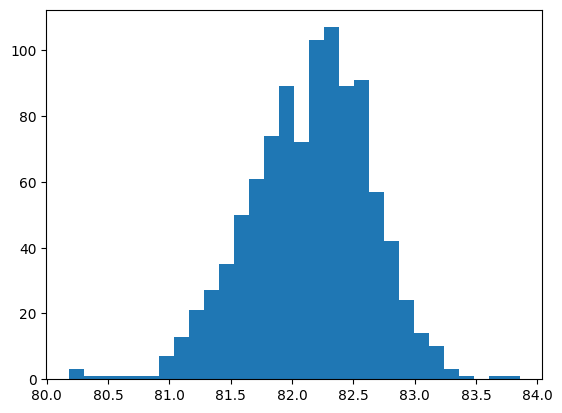

In [145]:
# loop 1000 times of sample size 30
mean_cup_points_1000 = []
for i in range(1000):
    mean_cup_points_1000.append(coffee_ratings.sample(n=30)['total_cup_points'].mean())

# plot the distribution
plt.hist(mean_cup_points_1000, bins = 30)
plt.show();

### Approximate sampling distribution

In [146]:

dice = pd.DataFrame({'die1': [1, 2, 3, 4, 5, 6],
                    'die2': [1, 2, 3, 4, 5, 6],
                    'die3': [1, 2, 3, 4, 5, 6],
                    'die4': [1, 2, 3, 4, 5, 6]}
                    )

# calculate the mean for each throw
dice['mean_roll'] = dice.mean(axis = 1)

### Standard errors and the central limit theorem

as sample size increases:
* the distribution of the averages will get closer to being normally distributed
* the width of the sampling distribution will get narrower

## Bootstrap distributions

### Introduction to bootstrapping

Bootstrap is the opposite of sampling from population
* sampling : going from a population to a smaller sample
* bootstrap : building up a theoretical population from the sample

- Process:
* make a resample of the same size as original sample
* calculate the satistic of interest

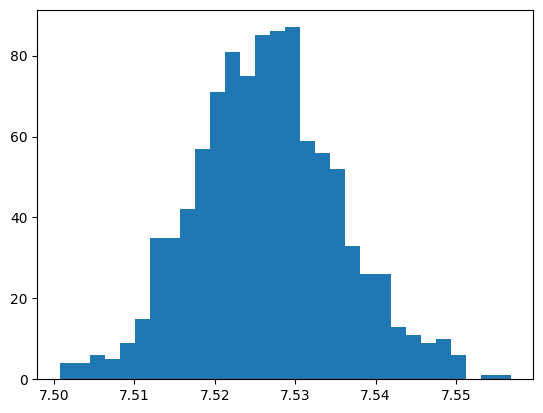

In [147]:
## bootstrapping coffee mean flavor
mean_flavors_1000 = []
for i in range(1000):
    mean_flavors_1000.append(np.mean(coffee_ratings.sample(frac=1, replace=True)['flavor']))

# plot the distribution
plt.hist(mean_flavors_1000, bins = 30)
plt.show();

In [148]:
table = feather.read_table('Sampling in Python\Data\spotify_2000_2020.feather')
spotify = table.to_pandas()
spotify.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_19244\2854124731.py:1: SyntaxWarning: invalid escape sequence '\D'
  table = feather.read_table('Sampling in Python\Data\spotify_2000_2020.feather')


,acousticness,artists,danceability,duration_ms,duration_minutes,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.97200,['David Bauer'],0.567,313293.0,5.221550,0.227,0.0,0w0D8H1ubRerCXHWYJkinO,0.601000,10.0,0.110,-13.441,1.0,Shout to the Lord,47.0,2000,0.0290,136.123,0.0396,2000.0
1,0.32100,['Etta James'],0.821,360240.0,6.004000,0.418,0.0,4JVeqfE2tpi7Pv63LJZtPh,0.000372,9.0,0.222,-9.841,0.0,Miss You,51.0,2000-12-12,0.0407,117.382,0.8030,2000.0
2,0.00659,['Quasimoto'],0.706,202507.0,3.375117,0.602,1.0,5pxtdhLAi0RTh1gNqhGMNA,0.000138,11.0,0.400,-8.306,0.0,Real Eyes,44.0,2000-06-13,0.3420,89.692,0.4790,2000.0
3,0.00390,['Millencolin'],0.368,173360.0,2.889333,0.977,0.0,3jRsoe4Vkxa4BMYqGHX8L0,0.000000,11.0,0.350,-2.757,0.0,Penguins & Polarbears,52.0,2000-02-22,0.1270,165.889,0.5480,2000.0
4,0.12200,['Steve Chou'],0.501,344200.0,5.736667,0.511,0.0,4mronxcllhfyhBRqyZi8kU,0.000000,7.0,0.279,-9.836,0.0,黃昏,53.0,2000-12-25,0.0291,78.045,0.1130,2000.0


In [149]:
# Here, spotify_sample is a subset of the spotify_population dataset. To make it easier to see how resampling works, a row index column called 'index' has been added, and only the artist name, song name, and danceability columns have been included.


### Comparing sampling and bootstrap distribution

In [150]:
# coffee focused subset
coffee_sample = coffee_ratings[['variety', 'country_of_origin', 'flavor']].reset_index().sample(n=500)
coffee_sample.head()


,index,variety,country_of_origin,flavor
283,283,Catuai,Costa Rica,7.42
700,700,Typica,Mexico,7.50
272,272,Typica,Mexico,7.67
12,12,Other,United States,8.67
73,73,Bourbon,Brazil,8.00


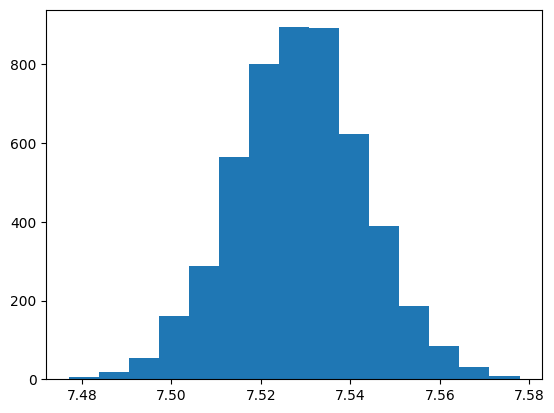

In [151]:
# bootstrap of coffee mean flavor
mean_flavors_5000 = []
for i in range(5000):
    mean_flavors_5000.append(np.mean(coffee_sample.sample(frac=1, replace=True)['flavor']))

bootstrap_distn = mean_flavors_5000

plt.hist(bootstrap_distn, bins = 15)
plt.show();

# Hypothesis testing
## Hypothesis tests & z-scores

In [152]:
# import data
table = feather.read_table('Hypothesis Testing in Python\Data\dem_votes_potus_12_16.feather')
sample_dem_data = table.to_pandas()
sample_dem_data.head()

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_19244\3785300650.py:2: SyntaxWarning: invalid escape sequence '\D'
  table = feather.read_table('Hypothesis Testing in Python\Data\dem_votes_potus_12_16.feather')


,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


In [153]:
import pingouin

sample_dem_data['diff'] = sample_dem_data['dem_percent_12'] - sample_dem_data['dem_percent_16']

# conduct t-test on diff
pingouin.ttest(x=sample_dem_data['diff'], y=0, alternative='two-sided')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",1.354985,2.246e+111,NaN


In [154]:
# conduct paired t-test
pingouin.ttest(x=sample_dem_data['dem_percent_12'], y=sample_dem_data['dem_percent_16'], paired=True, alternative='two-sided')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",0.454202,2.246e+111,NaN


# Supervised learning with scikit-learn
## classification

## Regression
### Introduction to regression

Predicting blood glucose levels

In [155]:
import pandas as pd
# import diabetes dataset
diabetes_df = pd.read_csv('Supervised Learning with scikit-learn\Data\diabetes_clean.csv')

# display data
diabetes_df.head()


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_19244\3667072460.py:3: SyntaxWarning: invalid escape sequence '\D'
  diabetes_df = pd.read_csv('Supervised Learning with scikit-learn\Data\diabetes_clean.csv')


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [156]:
# remove rows that has value 0
diabetes_df = diabetes_df[diabetes_df['glucose'] != 0]
diabetes_df = diabetes_df[diabetes_df['bmi'] != 0]

# creating feature (X) and target (Y) variables
X = diabetes_df.drop("glucose", axis=1).values
y = diabetes_df["glucose"].values

print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [157]:
# making predictions from a single feature
X_bmi = X[:, 4]
print(y.shape, X_bmi.shape)

(752,) (752,)


(752, 1)


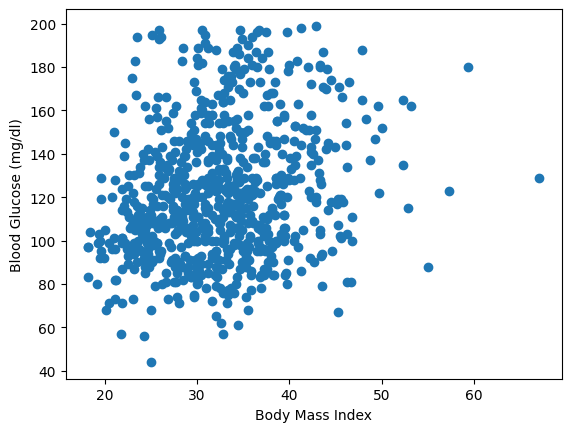

In [158]:
X_bmi = X_bmi.reshape(-1, 1)
print(X_bmi.shape)

import matplotlib.pyplot as plt
plt.scatter(X_bmi, y)
plt.ylabel("Blood Glucose (mg/dl)")
plt.xlabel("Body Mass Index")
plt.show();

# remove zeros from bmi and glucose


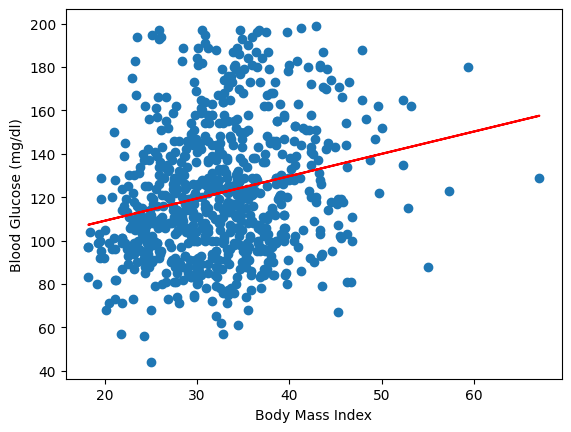

In [159]:
# fitting a regression model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_bmi, y)
predictions = reg.predict(X_bmi)
plt.scatter(X_bmi, y)
plt.plot(X_bmi, predictions, color = 'red')
plt.ylabel("Blood Glucose (mg/dl)")
plt.xlabel("Body Mass Index")
plt.show();

### The basics of linear regression

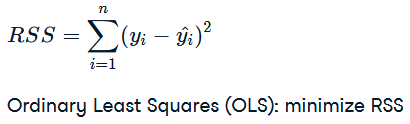

In [160]:
# Linear regression using all features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)

R-squared : variance in target values explained by the features
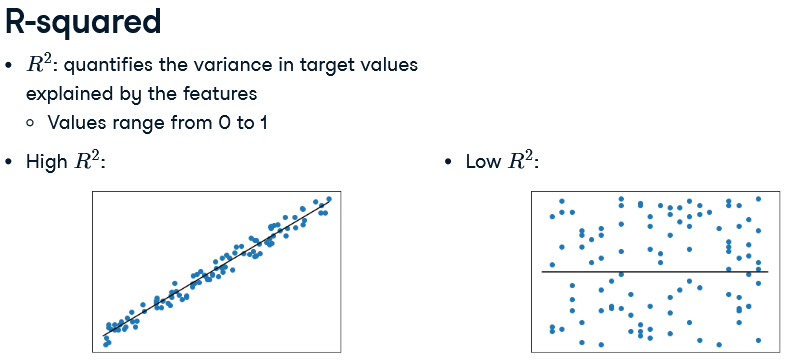

In [161]:
# R-squared in scikit-learn
reg_all.score(X_test, y_test)

0.3538028618676814

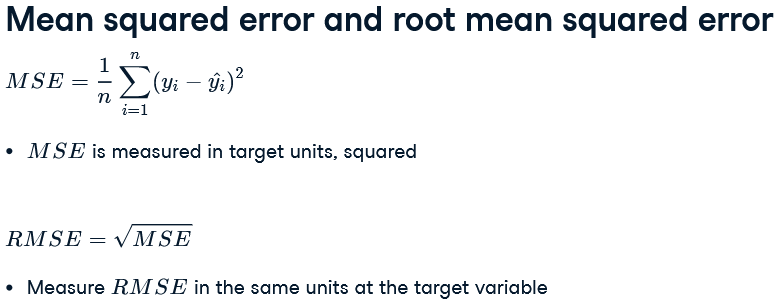

### Cross-validation
* Model performance depend on the way we split the data

In [162]:
# cross validation
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)
reg = LinearRegression()
cv_results = cross_val_score(reg, X, y, cv=kf)

# evaluating cross-validation performance
import numpy as np
print(cv_results)

print(np.mean(cv_results), np.std(cv_results))

print(np.quantile(cv_results, [0.025, 0.975]))

[0.31239631 0.39992274 0.38698031 0.19731639 0.32317527 0.3320924 ]
0.32531390402925 0.0657900382455161
[0.21170138 0.39830494]


In [2]:
# import SparkSession
from pyspark.sql import SparkSession

# initialize SparkSession
spark = SparkSession.builder.appName('MySparkApp').getOrCreate()
# builder() = sets up a session
# appName() = name of the session (manage multiple pyspark application)
# getOrCreate() = get the session or create a new one

# create a dataframe
census_df = spark.read.csv('census.csv',['gender', 'age'])

# show the dataframe
census_df.show()

PySparkTypeError: [NOT_STR_OR_STRUCT] Argument `schema` should be a str or structType, got list.

In [3]:
import openai

In [2]:
pip install openai

   ---------------------------------------- 0.0/599.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/599.1 kB ? eta -:--:--
   ---------------------------------------- 599.1/599.1 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 506.4 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 506.4 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 506.4 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 506.4 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 506.4 kB/s eta 0:00:03
   ---------- -----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
